In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.retrieve_wmapi import retrieve_top_articles_by_pageviews, retrieve_edit_counts_edit_types_lang, retrieve_pageviews_aggregate,retrieve_edits_for_protected_articles_parallel, retrieve_pageviews_user_types_lang, retrieve_pageviews_for_protected_articles,retrieve_pageviews_for_protected_articles_parallel

In [3]:
views_en_all = retrieve_pageviews_aggregate('en', 20220101, end=20230101)
views_en_user = retrieve_pageviews_aggregate('en', 20220101, end=20230101, agent='user')
views_top_pages = retrieve_top_articles_by_pageviews('en', 20220101, end=20230101, n_jobs=10)
edits_en_all = retrieve_edit_counts_edit_types_lang('en', 20220101, end=20230101)

In [4]:
df_redirects = pd.read_csv('data/supplementary/spell_redirects.zip')
df_spells = pd.read_csv('data/protections/spells.csv.zip', parse_dates=['start', 'end', 'start_day', 'end_day'])

# Fix time-constrained spells that are labeled incorrectly in the dataset
df_spells.loc[df_spells.end < pd.to_datetime('2000-01-01', utc=True), 'end'] = df_spells.loc[df_spells.end < pd.to_datetime('2000-01-01', utc=True), 'end_day'] = pd.NaT

df_spells_rel = df_spells[(df_spells.type=='edit')].copy()
df_spells_rel_red = df_redirects[~pd.isna(df_redirects.redirect)].merge(df_spells_rel, on='title', how='left')
df_spells_rel_red = df_spells_rel_red[~pd.isna(df_spells_rel_red.type)].drop(['title'], axis=1).rename({'redirect': 'title'}, axis=1)

# read and vis

In [5]:
from scripts.descriptive import plot_views, plot_views_with_percentage


In [6]:
df_relspells = df_spells_rel_red[df_spells_rel_red.type=='edit'].copy()
df_relspells.start.fillna(pd.to_datetime('2000-01-01', utc=True), inplace=True)
df_relspells.start_day = df_relspells.start.dt.date
df_relspells.end.fillna(pd.to_datetime('2025-01-01', utc=True), inplace=True)
df_relspells.end_day = df_relspells.end.dt.date

In [7]:
df_protect_red = pd.read_csv('data/supplementary/views_protect_with_red_all.csv.zip')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
edits_en_sum = edits_en_all.groupby('date').edits.sum().reset_index()
edits_en_sum['type'] = 'edits-all'

In [9]:
def format_protected(df_p, value_col = 'views', type_name = 'views-protected'):
    df_prot_unq = df_p.drop_duplicates(['date', 'article'])
    df_prot_unq[value_col] = pd.to_numeric(df_prot_unq[value_col], errors='coerce')
    df_prot_unq_ok = df_prot_unq[~pd.isna(df_prot_unq[value_col])].copy()
    df_daily_prot = df_prot_unq_ok.groupby('date')[value_col].sum()
    df_daily_prot = df_daily_prot.reset_index().rename({value_col: 'value'}, axis=1)
    df_daily_prot.date = pd.to_datetime(df_daily_prot.date)
    df_daily_prot['type'] = type_name
    return df_daily_prot


In [10]:

df_daily_protviews = format_protected(df_protect_red)
df_daily_protviews_22 = df_daily_protviews[df_daily_protviews.date.dt.year == 2022]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
views_en_all_22 = views_en_all[views_en_all.date.dt.year == 2022].copy()
views_en_all_22['value'] = views_en_all_22['views']
views_en_all_22.type = 'views-all'

In [12]:
views_top_pages_22 = views_top_pages[~pd.isna(views_top_pages.date) & (views_top_pages.year == '2022')].copy()
views_top_pages_22= views_top_pages_22[~views_top_pages_22.article.astype(str).str.contains('^(User|Talk|Template|Wikipedia|File|Portal|Wikipedia|MediaWiki|Module|Category|WP|Help|Draft|Special)(_[Tt]alk)?_?:')]
views_top_pages_22['date'] = pd.to_datetime(views_top_pages_22.date, utc=True).dt.date
df_daily_topviews = format_protected(views_top_pages_22, type_name='views-top')

In [13]:
views_top_with_spells = views_top_pages_22.merge(df_relspells, right_on='title', left_on='article', how='left')
views_top_with_spells = views_top_with_spells[views_top_with_spells.date.between(views_top_with_spells.start_day, views_top_with_spells.end_day, inclusive='both')]
df_daily_top_prot_views = format_protected(views_top_with_spells, type_name='views-top-protected')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Plot

In [ ]:
import matplotlib.pyplot as plt
from scripts.descriptive import plot_views_only_left
from scripts.descriptive import plot_percentage_bar_pageviews


In [14]:
sum_views_all = views_en_all_22.value.sum()
sum_views_all_protected = df_daily_protviews_22.value.sum()
sum_views_all_unprotected = sum_views_all - sum_views_all_protected
sum_views_top = df_daily_topviews.value.sum()
sum_views_top_protected = df_daily_top_prot_views.value.sum()
sum_views_top_unprotected = sum_views_top - sum_views_top_protected

In [15]:
df_barcharts = pd.DataFrame([
    [sum_views_all_protected, sum_views_all_protected/sum_views_all, 'All Article Views', 'Protected'], 
    [sum_views_all_unprotected, sum_views_all_unprotected/sum_views_all, 'All Article Views', 'Unprotected'],
    [sum_views_top_protected, sum_views_top_protected/sum_views_top, 'Top-Article Views', 'Protected'],
    [sum_views_top_unprotected, sum_views_top_unprotected/sum_views_top, 'Top-Article Views', 'Unprotected']],
    columns=['Value', 'Percent', 'Article Type', 'Protection'])
df_barcharts_row = df_barcharts.pivot(index="Protection", columns=['Article Type'], values=['Value', 'Percent'])

,Value,Percent,Article Type,Protection
0,1.754330e+10,0.152841,All Article Views,Protected
1,9.723808e+10,0.847159,All Article Views,Unprotected
2,6.080611e+09,0.563736,Top-Article Views,Protected
3,4.705662e+09,0.436264,Top-Article Views,Unprotected


[0.152841   0.56373608]
[0.847159   0.43626392]


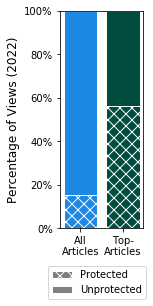

In [86]:
plot_percentage_bar_pageviews(sum_views_all_protected, sum_views_all, sum_views_top_protected, sum_views_top)

,date,views,type,value,protected
0,2022-01-01,309400637.0,views-all,309400637.0,False
1,2022-01-02,323259792.0,views-all,323259792.0,False
2,2022-01-03,313272140.0,views-all,313272140.0,False
3,2022-01-04,301076635.0,views-all,301076635.0,False
4,2022-01-05,300782348.0,views-all,300782348.0,False
...,...,...,...,...,...
360,2022-12-27,NaN,views-top-protected,17179430.0,True
361,2022-12-28,NaN,views-top-protected,15402268.0,True
362,2022-12-29,NaN,views-top-protected,16658999.0,True
363,2022-12-30,NaN,views-top-protected,19351997.0,True


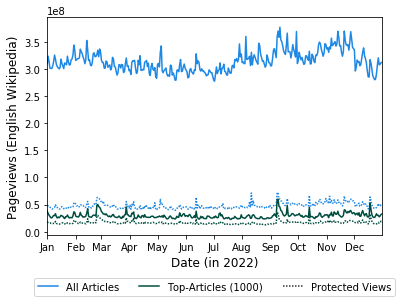

In [87]:
plot_views_only_left(views_en_all_22, df_daily_protviews_22, df_daily_topviews, df_daily_top_prot_views)